# 시작

In [10]:
import os, io
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from IPython.display import display

from google.cloud import vision
import keras_ocr
import pytesseract

In [11]:
def get_image_files():
    path = os.getenv('HOME') + '/aiffel/ocr_python'
    files = [
        'airport1.jpg',
        'airport2.jpg',
        'airport3.jpg',
        'airport4.jpg',
        'airport5.jpg'
    ]
    image_files = []
    for file in files:
        image_files.append(os.path.join(path, file))
    return image_files

In [12]:
image_files = get_image_files()
image_files

['/home/ssac5/aiffel/ocr_python/airport1.jpg',
 '/home/ssac5/aiffel/ocr_python/airport2.jpg',
 '/home/ssac5/aiffel/ocr_python/airport3.jpg',
 '/home/ssac5/aiffel/ocr_python/airport4.jpg',
 '/home/ssac5/aiffel/ocr_python/airport5.jpg']

# Google Vision

In [13]:
def draw_boxes(path, bounds):
    image = Image.open(path)
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, 'red')
    display(image)


def read_with_google_cloud_vision(path, target):
    target = target.lower()
    !ls -l $GOOGLE_APPLICATION_CREDENTIALS
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'
    client = vision.ImageAnnotatorClient()
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)
    response = client.text_detection(image=image)
    annotations = response.text_annotations
    bounds = []
    for annotation in annotations:
        if target in annotation.description.lower():
            bounds.append(annotation.bounding_poly)
    draw_boxes(path, bounds)

-rw-rw-r-- 1 ssac5 ssac5 2385 Mar 11 10:03 /home/ssac5/aiffel/ocr_python/my_google_api_key.json


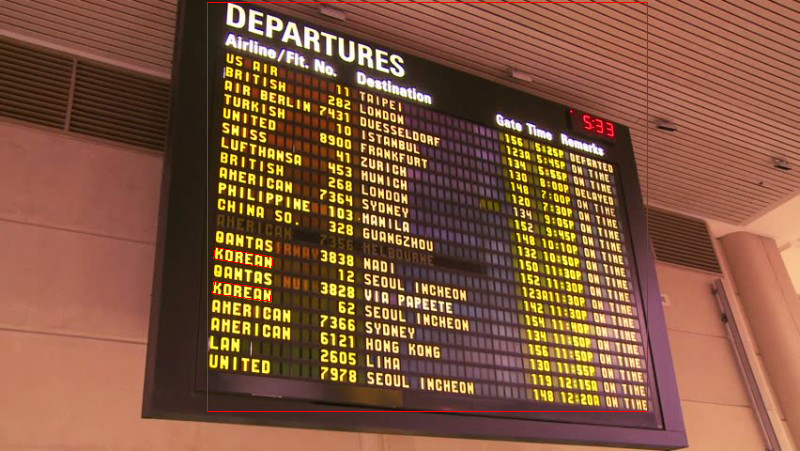

-rw-rw-r-- 1 ssac5 ssac5 2385 Mar 11 10:03 /home/ssac5/aiffel/ocr_python/my_google_api_key.json


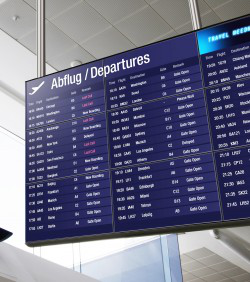

-rw-rw-r-- 1 ssac5 ssac5 2385 Mar 11 10:03 /home/ssac5/aiffel/ocr_python/my_google_api_key.json


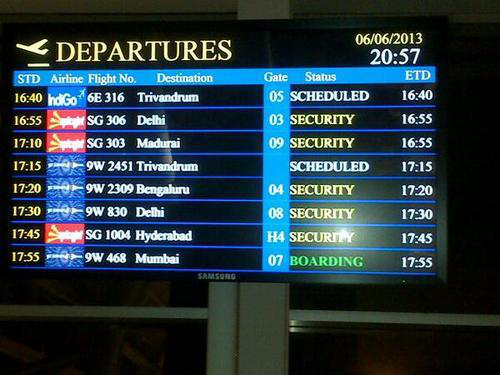

-rw-rw-r-- 1 ssac5 ssac5 2385 Mar 11 10:03 /home/ssac5/aiffel/ocr_python/my_google_api_key.json


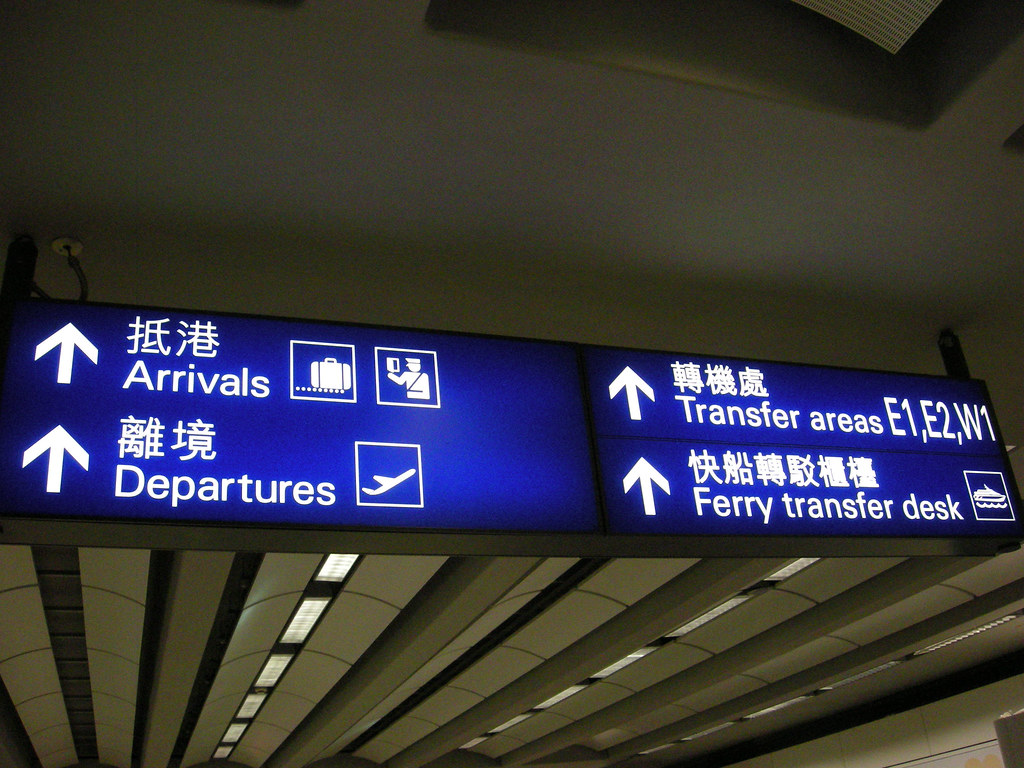

-rw-rw-r-- 1 ssac5 ssac5 2385 Mar 11 10:03 /home/ssac5/aiffel/ocr_python/my_google_api_key.json


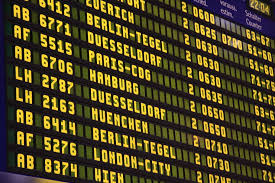

In [14]:
target = 'korean'
for image_file in image_files:
    read_with_google_cloud_vision(image_file, target)

# Keras

In [15]:
def read_with_keras(path, target):
    target = target.lower()
    pipeline = keras_ocr.pipeline.Pipeline()
    predictions = pipeline.recognize([path])
    founds = []
    for prediction in predictions:
        for text, bounds in prediction:
            if target in text.lower():
                founds.append((text, bounds))
    image = keras_ocr.tools.read(path)
    keras_ocr.tools.drawAnnotations(image=image, 
                                    predictions=founds)

Looking for /home/ssac5/.keras-ocr/craft_mlt_25k.h5
Looking for /home/ssac5/.keras-ocr/crnn_kurapan.h5


/home/ssac5/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


Looking for /home/ssac5/.keras-ocr/craft_mlt_25k.h5
Looking for /home/ssac5/.keras-ocr/crnn_kurapan.h5
Looking for /home/ssac5/.keras-ocr/craft_mlt_25k.h5
Looking for /home/ssac5/.keras-ocr/crnn_kurapan.h5
Looking for /home/ssac5/.keras-ocr/craft_mlt_25k.h5
Looking for /home/ssac5/.keras-ocr/crnn_kurapan.h5
Looking for /home/ssac5/.keras-ocr/craft_mlt_25k.h5
Looking for /home/ssac5/.keras-ocr/crnn_kurapan.h5


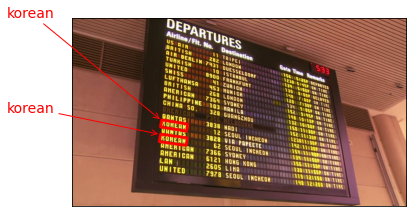

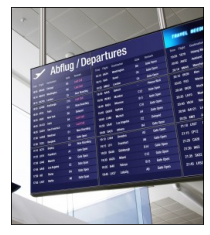

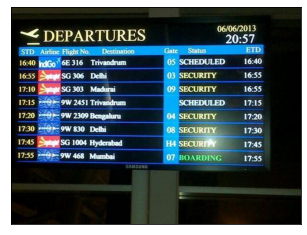

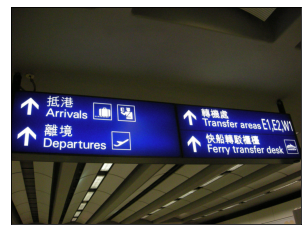

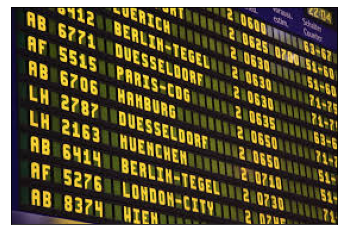

In [16]:
target = 'korean'
for image_file in image_files:
    read_with_keras(image_file, target)

# Pytesseract

In [17]:
def draw_boxes(path, bounds):
    image = Image.open(path)
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound[0], bound[1],
            bound[2], bound[1],
            bound[2], bound[3],
            bound[0], bound[3]], None, 'red')
    display(image)
    
def read_with_pytesseract(path, target):
    target = target.lower()
    custom_oem_psm_config = r'--oem 3 --psm 3'

    image = Image.open(path)
    recognized_data = pytesseract.image_to_data(
        image, 
        lang='eng', 
        config=custom_oem_psm_config,
        output_type=pytesseract.Output.DICT
    )
    bounds = []
    top_level = max(recognized_data['level'])
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
        if level == top_level:
            if target in recognized_data['text'][i].lower():
                left = recognized_data['left'][i]
                top = recognized_data['top'][i]
                width = recognized_data['width'][i]
                height = recognized_data['height'][i]
                bound = (
                    left,
                    top,
                    left+width,
                    top+height
                )
                bounds.append(bound)
    draw_boxes(path, bounds)

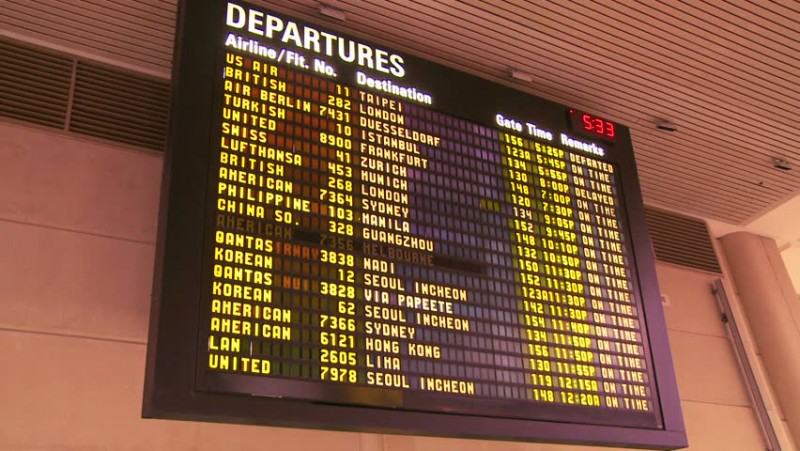

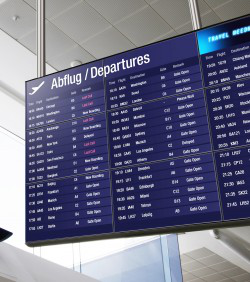

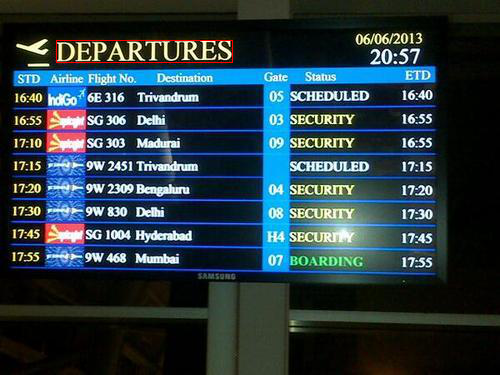

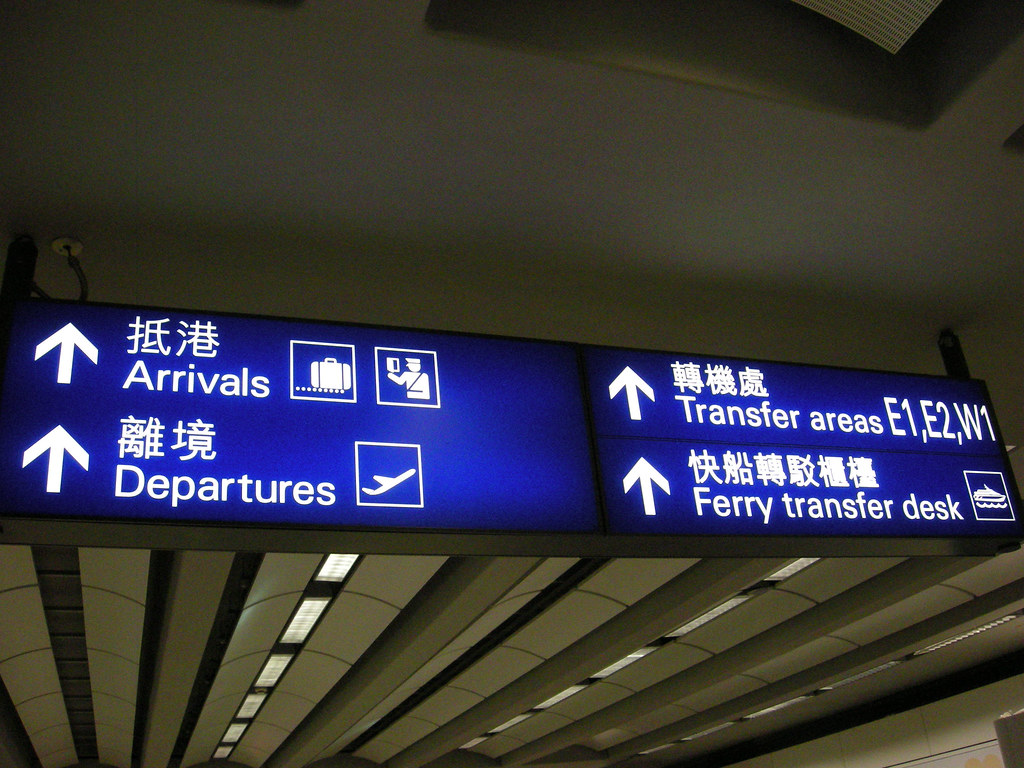

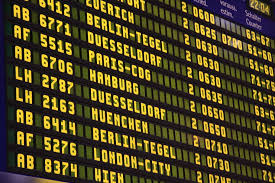

In [18]:
target = 'departures'
for image_file in image_files:
    read_with_pytesseract(image_file, target)

# 결론

공항에는 처음 방문자를 위해 많은 표지들이 있다.   
그러나 너무 많은 정보가 있기 때문에 내가 찾고자 하는것이 한눈에 보이지 않는다.   
그래서 앱을 켜고 다니면 내가 원하는 정보를 강조해서 보여주는 서비스를 구현해본다.   

찾고자 하는 정보로는 출구, 입구, 탑승구, 목적 국가/도시 등이 될 수 있다.

Google Vision과 케라스는 아주 작은 글자와 비틀어진 글자도 잘 찾아내지만,    
Pytesseract는 비틀어진 글자는 잘 찾지 못하고, 작은 글자도 잘 찾지 못했다.